## Métodos de Monte-Carlo


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import yfinance as yf
np.random.seed(1984)
%matplotlib inline
import pandas_datareader as dr
from datetime import date, datetime, timedelta
plt.style.use("ggplot")
import statsmodels.api as sm

In [3]:
# abrir el archivo
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)
print(df.head())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [4]:
# Limpiar los datos y seleccionar una variable de interés (Global_active_power)
# Filtramos los datos no disponibles
df = df.dropna(subset=['Global_active_power'])

In [5]:
# Convertimos Global_active_power a float
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
globalpower = df['Global_active_power']

In [7]:
# convertir date a tipo fecha
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [8]:
# tipo de dato que es date
print(df['Date'].dtype)

datetime64[ns]


In [9]:
# agrupar por día
daily_data = df.groupby(df['Date'].dt.date)['Global_active_power'].sum()
print(daily_data.head())

Date
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Name: Global_active_power, dtype: float64


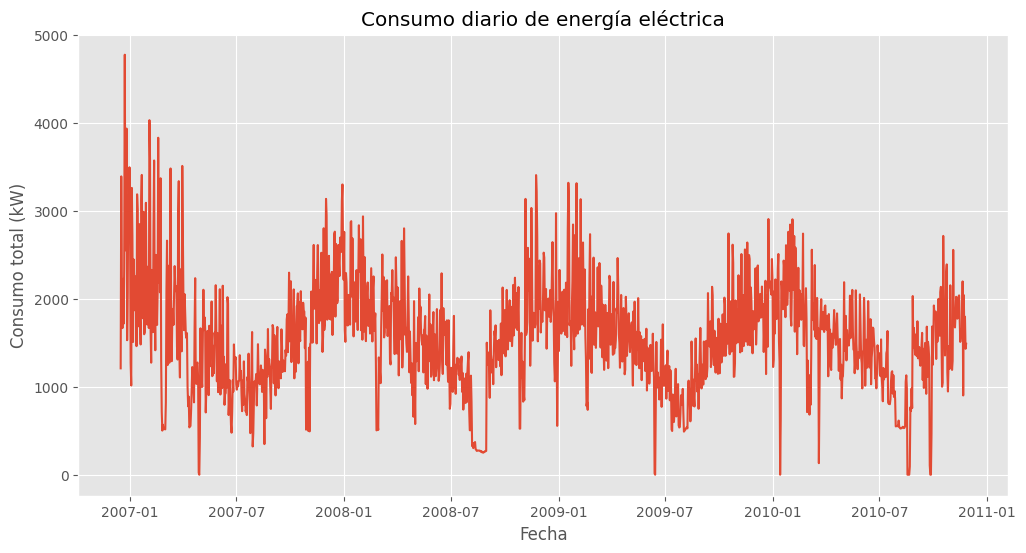

In [10]:
# graficar daily_data
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data.values)
plt.title('Consumo diario de energía eléctrica')
plt.xlabel('Fecha')
plt.ylabel('Consumo total (kW)')
plt.grid(True)
plt.show()

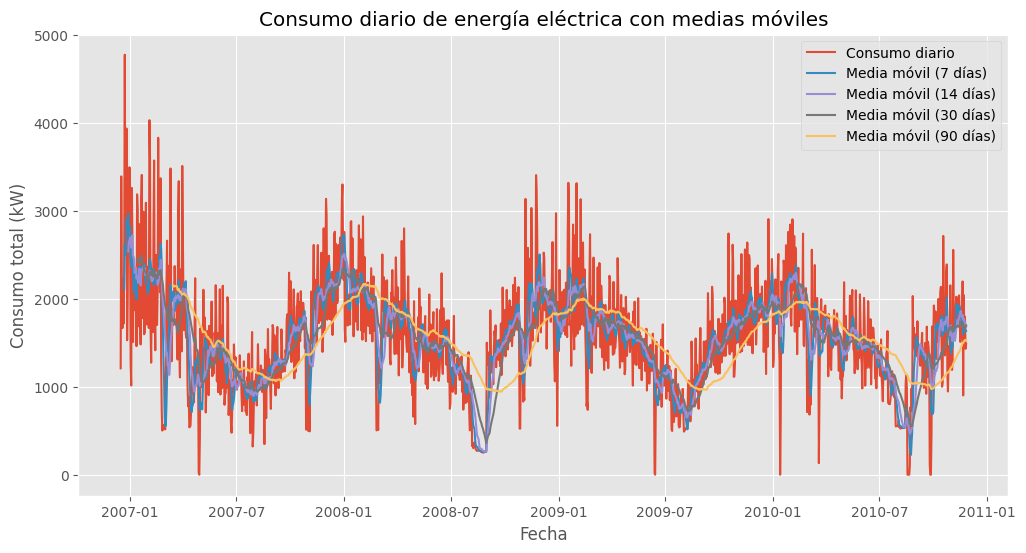

In [11]:
# calcular la media movil ideal

# Calcular la media móvil con diferentes ventanas
window_sizes = [7, 14, 30, 90]  # Diferentes tamaños de ventana para la media móvil
rolling_means = {}

for window_size in window_sizes:
    rolling_means[window_size] = daily_data.rolling(window=window_size).mean()

# Visualizar las medias móviles
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data.values, label='Consumo diario')

for window_size, rolling_mean in rolling_means.items():
    plt.plot(daily_data.index, rolling_mean.values, label=f'Media móvil ({window_size} días)')

plt.title('Consumo diario de energía eléctrica con medias móviles')
plt.xlabel('Fecha')
plt.ylabel('Consumo total (kW)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# selecciona la mejor media movil menor a 90 respecto al error cuadratico

from sklearn.metrics import mean_squared_error

# Calcular el error cuadrático medio para cada media móvil
errors = {}
for window_size, rolling_mean in rolling_means.items():
  if window_size < 90:
    # Asegurarse de que los datos tengan el mismo tamaño
    valid_indices = rolling_mean.notna()
    rmse = mean_squared_error(daily_data[valid_indices], rolling_mean[valid_indices], squared=False)
    errors[window_size] = rmse

# Encontrar la media móvil con el menor error
best_window_size = min(errors, key=errors.get)
print(f"La mejor media móvil (menor a 90 días) con respecto al error cuadrático es de {best_window_size} días.")

La mejor media móvil (menor a 90 días) con respecto al error cuadrático es de 7 días.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# Hacer media móvil para n = 7
n = 7
k = len(daily_data.values)
mmovil = np.empty(k)
mmovil[:] = np.nan
ini = 0
for i in range(n-1,k):
  mmovil[i] = np.sum(daily_data.values[ini:i+1])/n
  ini += 1
mmovil

array([          nan,           nan,           nan, ..., 1676.54114286,
       1644.97142857, 1633.21485714])

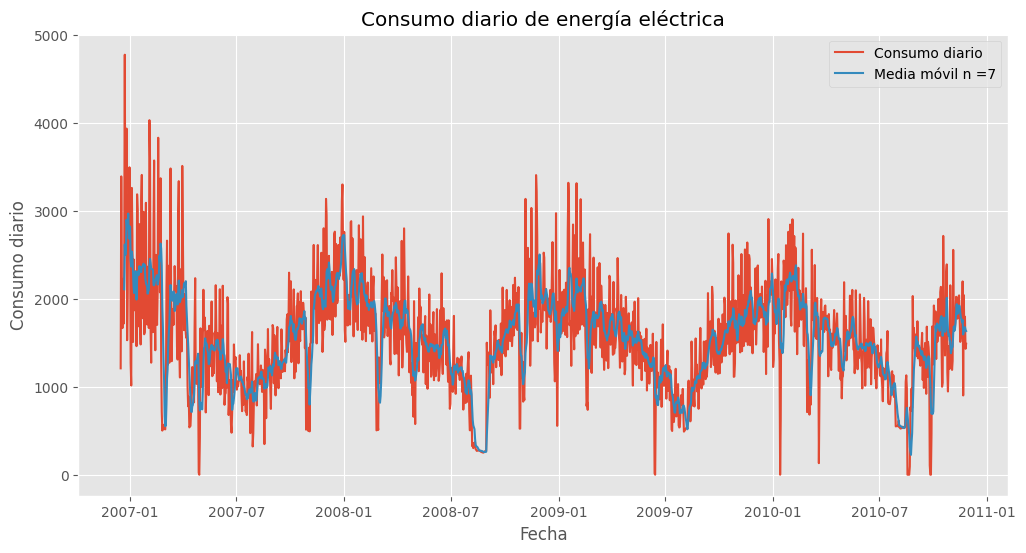

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data.values, label='Consumo diario')
plt.plot(daily_data.index, mmovil, label='Media móvil n =7')
plt.title('Consumo diario de energía eléctrica')
plt.xlabel('Fecha')
plt.ylabel('Consumo diario')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
power=daily_data.values

In [16]:
date=daily_data.index

In [17]:
#Convertir daily_data en data frame
dataset = pd.DataFrame({'date': daily_data.index, 'power': daily_data.values.flatten()})
print(dataset.head())

         date     power
0  2006-12-16  1209.176
1  2006-12-17  3390.460
2  2006-12-18  2203.826
3  2006-12-19  1666.194
4  2006-12-20  2225.748


In [18]:
# Estacionalidad
est = power - mmovil
est

array([          nan,           nan,           nan, ...,  119.70685714,
       -213.80742857, -145.11085714])

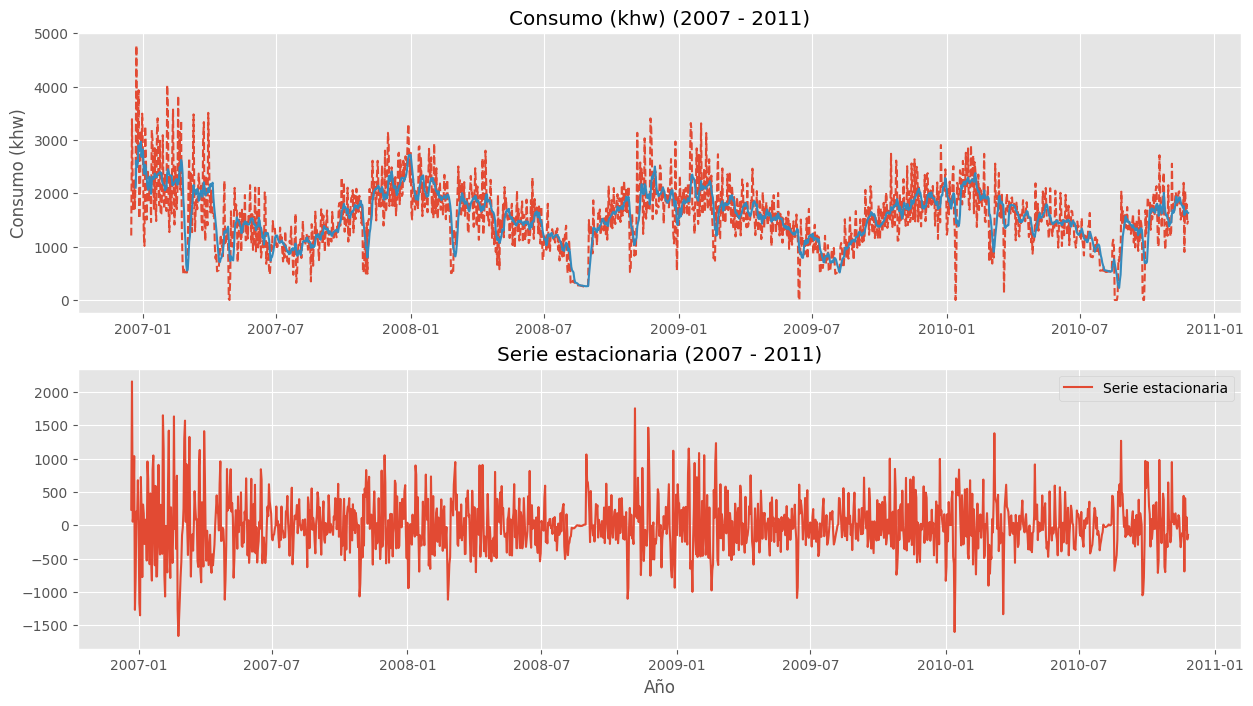

In [19]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(dataset['date'],dataset['power'], '--', label='Ingresos')
plt.plot(dataset['date'],mmovil, label='Media móvil n =3')
plt.title('Consumo (khw) (2007 - 2011)')
plt.ylabel('Consumo (khw)')
plt.subplot(212)
plt.plot(dataset['date'],est, '-',label='Serie estacionaria')
plt.title('Serie estacionaria (2007 - 2011)')
plt.xlabel('Año')
plt.legend()
plt.show()

## Descomposición

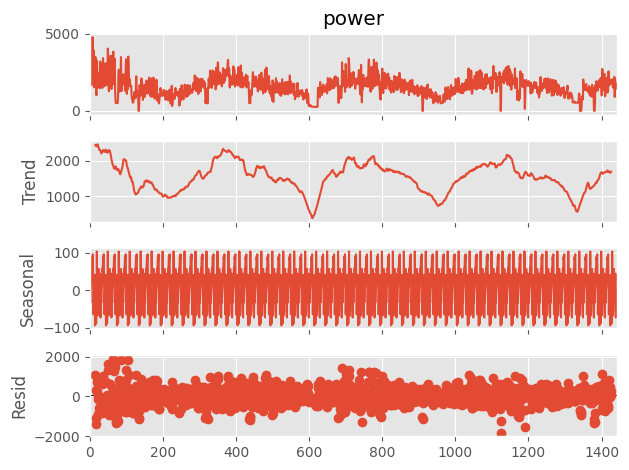

In [20]:
# Replace 'freq' with 'period'
descomposicion = sm.tsa.seasonal_decompose(dataset['power'], model='additive', period=30)
descomposicion.plot();

## Modelo ARIMA

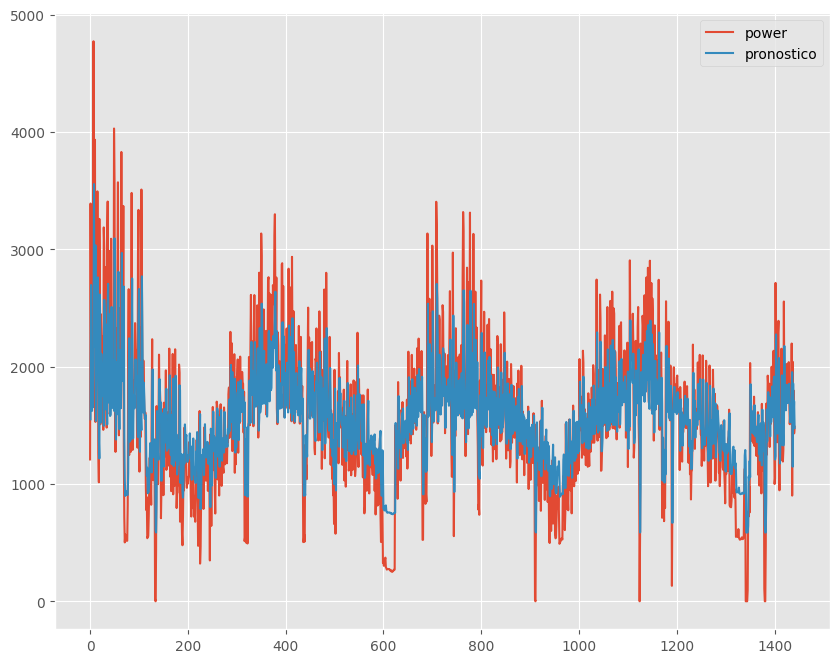

In [21]:
from statsmodels.tsa.arima.model import ARIMA
modelo = ARIMA(dataset['power'].iloc[1:], order=(1,0,0))
resultados = modelo.fit()
dataset['pronostico'] = resultados.fittedvalues
plot = dataset[['power', 'pronostico']].plot(figsize=(10, 8));

In [22]:
# Error cuadrático
dataset.dropna(inplace=True)
rmse_arima = mean_squared_error(
    dataset['power'], dataset['pronostico'], squared=False
)
print(f"El error cuadrático medio del modelo ARIMA es: {rmse_arima}")

El error cuadrático medio del modelo ARIMA es: 484.8738206283136


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# Revisamos estadísticas clave de consumo de energía
mean_consumption = dataset['power'].mean()  # Media
std_consumption = dataset['power'].std()    # Desviación estándar
print(f"Media del consumo de energía: {mean_consumption} kW")
print(f"Desviación estándar del consumo de energía: {std_consumption} kW")

Media del consumo de energía: 1551.572301179736 kW
Desviación estándar del consumo de energía: 617.4455411931134 kW


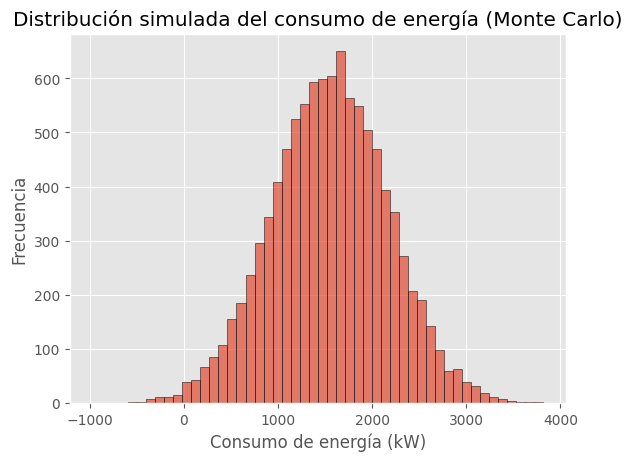

In [25]:
# Definir la simulación Monte Carlo
# Vamos a simular 10000 escenarios de consumo de energía futura
num_simulations = 10000
# Simulamos escenarios de consumo basado en una distribución normal
simulated_consumption = np.random.normal(loc=mean_consumption, scale=std_consumption, size=num_simulations)

# Visualizar los resultados
plt.hist(simulated_consumption, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribución simulada del consumo de energía (Monte Carlo)')
plt.xlabel('Consumo de energía (kW)')
plt.ylabel('Frecuencia')
plt.show()

# Datos simulados

In [26]:
# dataset con los datos simulados, convierte en dataset y coloca fechas, Empezar desde el día siguiente al último del dataset original

# Find the last date in the original dataset
last_date = dataset['date'].max()

# Create a list of dates starting from the day after the last date
dates = [last_date + timedelta(days=i) for i in range(1, len(simulated_consumption) + 1)]

# Create a DataFrame with the simulated data and dates
df_simulated = pd.DataFrame({'date': dates, 'power': simulated_consumption})

# Print the simulated dataset with dates
print(df_simulated)

# Concatenate the original and simulated datasets if needed
# df_combined = pd.concat([df_daily_data, df_simulated], ignore_index=True)

            date        power
0     2010-11-27  1534.961641
1     2010-11-28  1125.983337
2     2010-11-29  2104.888984
3     2010-11-30  1141.377092
4     2010-12-01  2182.222892
...          ...          ...
9995  2038-04-09  1538.609326
9996  2038-04-10  2338.383763
9997  2038-04-11  2111.490846
9998  2038-04-12   488.036015
9999  2038-04-13  2040.876474

[10000 rows x 2 columns]


In [27]:
# unir dataset y df_simulated

# Concatenate the original and simulated datasets
df_combined = pd.concat([dataset, df_simulated], ignore_index=True)

# Print the combined dataset
print(df_combined)

             date        power   pronostico
0      2006-12-17  3390.460000  1551.572311
1      2006-12-18  2203.826000  2695.723600
2      2006-12-19  1666.194000  1957.402914
3      2006-12-20  2225.748000  1622.889637
4      2006-12-21  1716.624000  1971.042727
...           ...          ...          ...
11436  2038-04-09  1538.609326          NaN
11437  2038-04-10  2338.383763          NaN
11438  2038-04-11  2111.490846          NaN
11439  2038-04-12   488.036015          NaN
11440  2038-04-13  2040.876474          NaN

[11441 rows x 3 columns]


In [28]:
# eliminar columna pronostico

# Assuming 'dataset' is your DataFrame with the 'pronostico' column
if 'pronostico' in df_combined.columns:
  df_combined = df_combined.drop('pronostico', axis=1)
  print("Columna 'pronostico' eliminada exitosamente.")
else:
  print("La columna 'pronostico' no existe en el DataFrame.")

Columna 'pronostico' eliminada exitosamente.


In [29]:
df_combined

,date,power
0,2006-12-17,3390.460000
1,2006-12-18,2203.826000
2,2006-12-19,1666.194000
3,2006-12-20,2225.748000
4,2006-12-21,1716.624000
...,...,...
11436,2038-04-09,1538.609326
11437,2038-04-10,2338.383763
11438,2038-04-11,2111.490846
11439,2038-04-12,488.036015


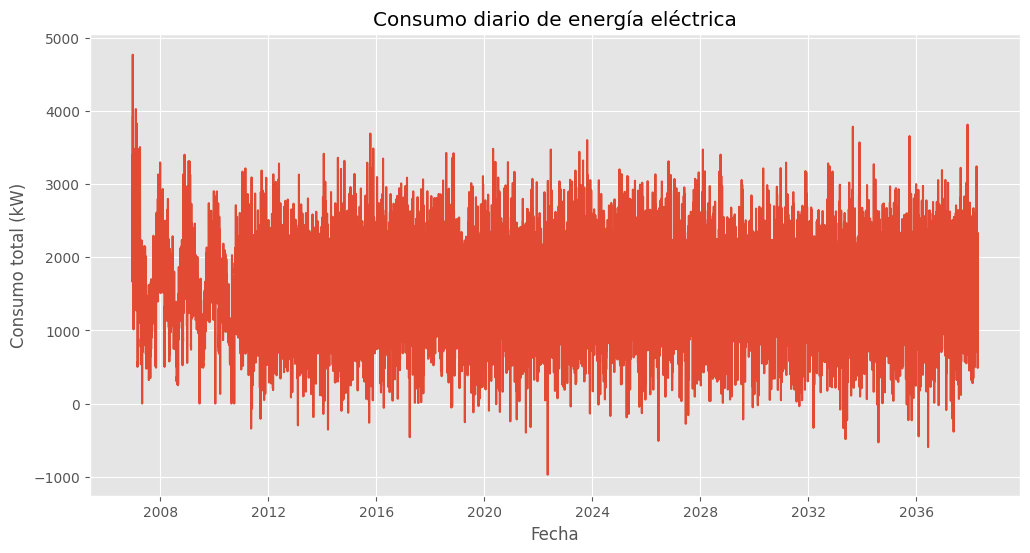

In [30]:
# graficar df_combined
plt.figure(figsize=(12, 6))
plt.plot(df_combined['date'] , df_combined['power'])
plt.title('Consumo diario de energía eléctrica')
plt.xlabel('Fecha')
plt.ylabel('Consumo total (kW)')
plt.grid(True)
plt.show()

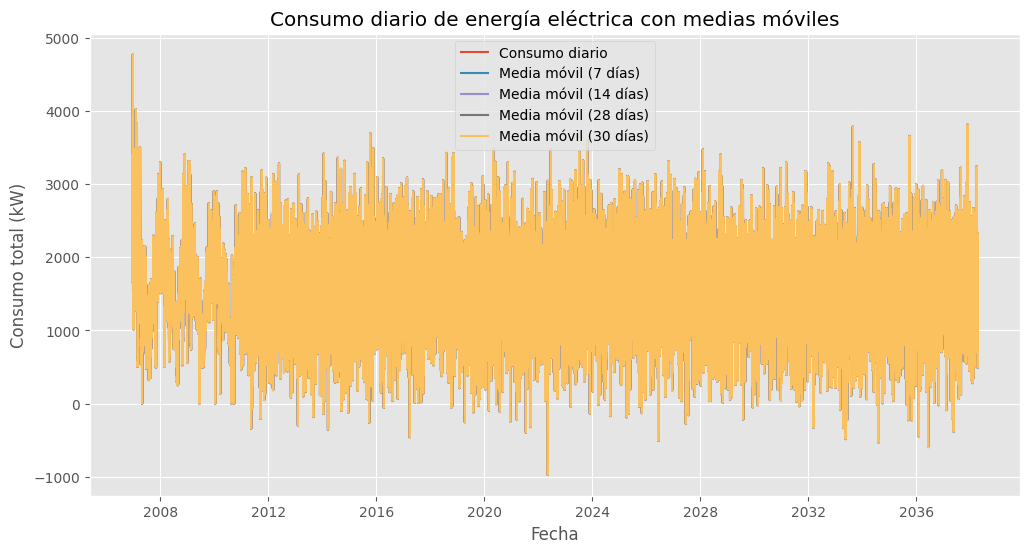

In [34]:
# calcular la media movil ideal
# Calcular la media móvil con diferentes ventanas
window_sizes = [7, 14, 28, 30]  # Diferentes tamaños de ventana para la media móvil
rolling_means = {}

for window_size in window_sizes:
    rolling_means[window_size] = df_combined['power'].rolling(window=window_size).mean()

# Visualizar las medias móviles
plt.figure(figsize=(12, 6))
plt.plot(df_combined['date'], df_combined['power'], label='Consumo diario')

for window_size, rolling_mean in rolling_means.items():
    plt.plot(df_combined['date'], df_combined['power'], label=f'Media móvil ({window_size} días)')

plt.title('Consumo diario de energía eléctrica con medias móviles')
plt.xlabel('Fecha')
plt.ylabel('Consumo total (kW)')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# selecciona la mejor media movil menor a 90 respecto al error cuadratico de df_combined

# Calcular el error cuadrático medio para cada media móvil
errors = {}
for window_size, rolling_mean in rolling_means.items():
  if window_size < 90:
    # Asegurarse de que los datos tengan el mismo tamaño
    valid_indices = rolling_mean.notna()
    rmse = mean_squared_error(df_combined['power'][valid_indices], rolling_mean[valid_indices], squared=False)
    errors[window_size] = rmse

# Encontrar la media móvil con el menor error
best_window_size = min(errors, key=errors.get)
print(f"La mejor media móvil (menor a 90 días) con respecto al error cuadrático es de {best_window_size} días.")

La mejor media móvil (menor a 90 días) con respecto al error cuadrático es de 7 días.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

In [51]:
# Hacer media móvil para n = 7
n = 7
k = len(df_combined['power'])
mmovil = np.empty(k)
mmovil[:] = np.nan
ini = 0
for i in range(n-1,k):
  mmovil[i] = np.sum(df_combined['power'][ini:i+1])/n
  ini += 1
mmovil

array([          nan,           nan,           nan, ..., 1744.66350037,
       1651.77505524, 1630.72181705])

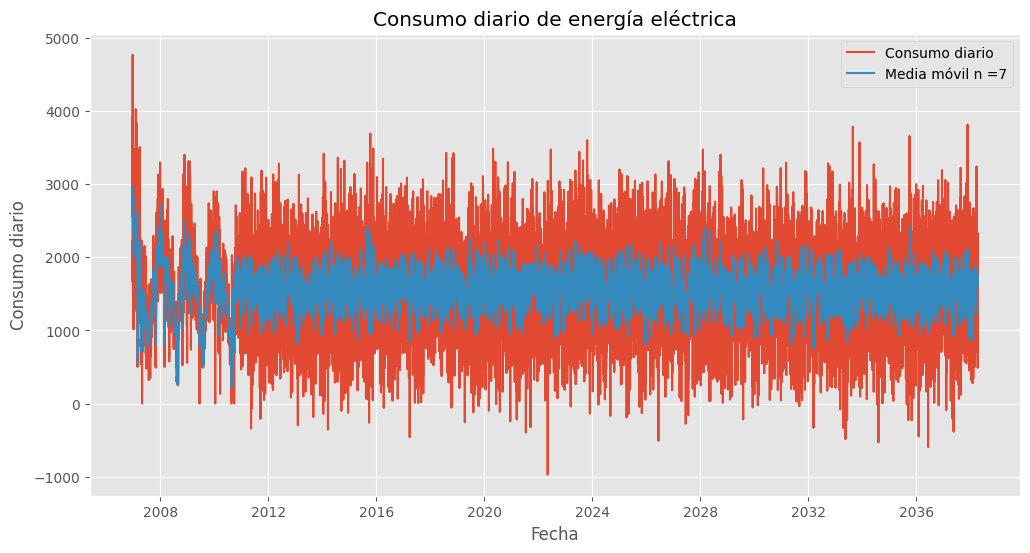

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(df_combined['date'], df_combined['power'], label='Consumo diario')
plt.plot(df_combined['date'], mmovil, label='Media móvil n =7')
plt.title('Consumo diario de energía eléctrica')
plt.xlabel('Fecha')
plt.ylabel('Consumo diario')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
power_combined=df_combined['power']

In [55]:
# Estacionalidad
est = power_combined - mmovil
est

,power
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
11436,-95.351251
11437,624.948932
11438,366.827345
11439,-1163.739040


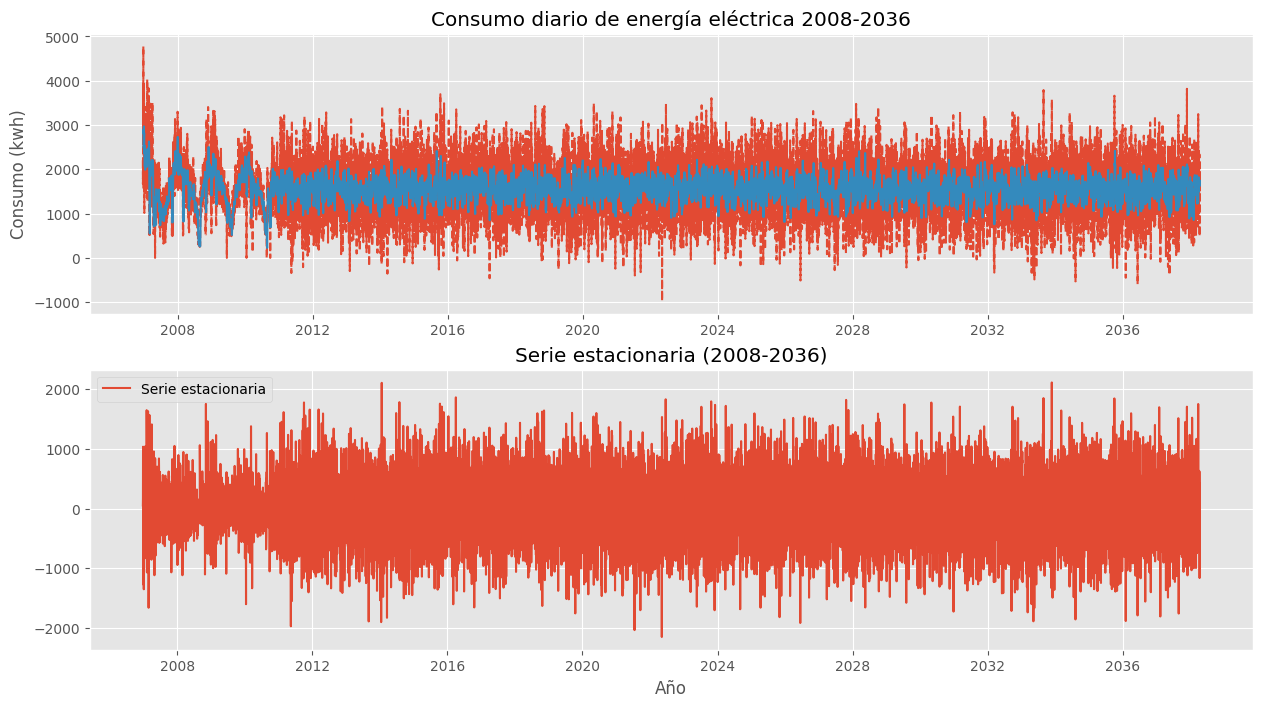

In [56]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(df_combined['date'],power_combined, '--', label='Ingresos')
plt.plot(df_combined['date'],mmovil, label='Media móvil n =3')
plt.title('Consumo diario de energía eléctrica 2008-2036')
plt.ylabel('Consumo (kwh)')
plt.subplot(212)
plt.plot(df_combined['date'],est, '-',label='Serie estacionaria')
plt.title('Serie estacionaria (2008-2036)')
plt.xlabel('Año')
plt.legend()
plt.show()

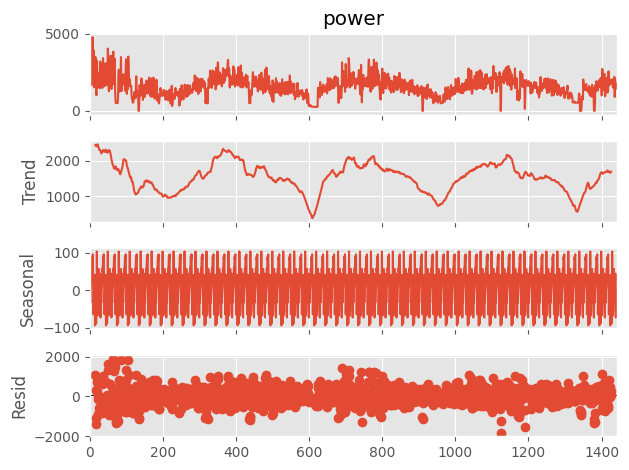

In [45]:
# Descomposición
descomposicion_com = sm.tsa.seasonal_decompose(df_combined['power'], model='additive', period=30)
descomposicion.plot();

## Modelo Arima

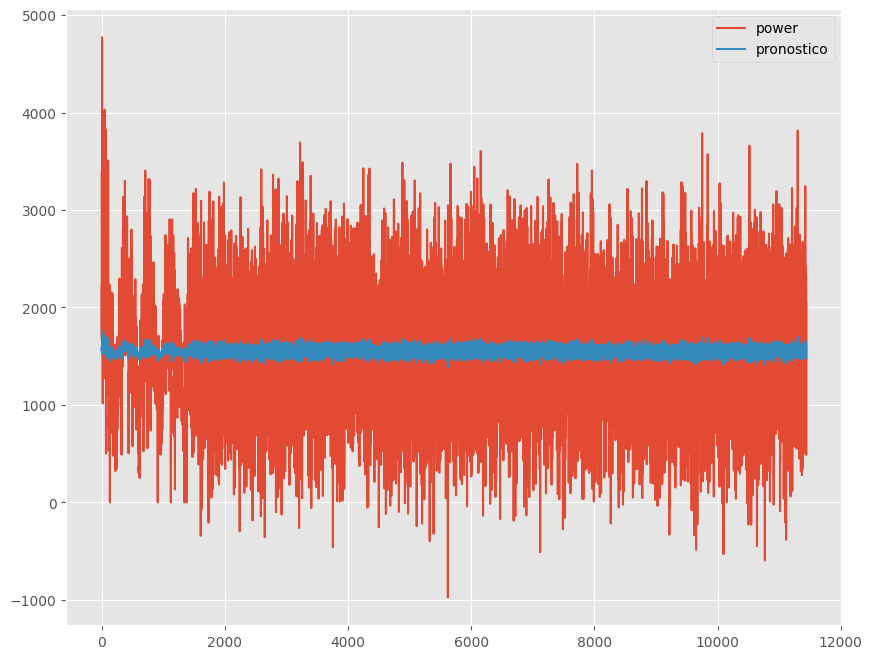

In [46]:
from statsmodels.tsa.arima.model import ARIMA
modelo = ARIMA(df_combined['power'].iloc[1:], order=(1,0,0))
resultados = modelo.fit()
df_combined['pronostico'] = resultados.fittedvalues
plot = df_combined[['power', 'pronostico']].plot(figsize=(10, 8));

In [47]:
# error cuadrático medio del modelo ARIMA
df_combined.dropna(inplace=True)
rmse_arima = mean_squared_error(
    df_combined['power'], df_combined['pronostico'], squared=False
)
print(f"El error cuadrático medio del modelo ARIMA es: {rmse_arima}")

El error cuadrático medio del modelo ARIMA es: 616.4808600737196


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
